In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.models.np import NeuralProcess
from activephasemap.utils.settings import initialize_model
from activephasemap.utils.simulators import UVVisExperiment
import matplotlib.ticker as ticker
import glob, json
from funcshape.functions import Function, SRSF, get_warping_function
from apdist.distances import AmplitudePhaseDistance as dist
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF_
from scipy.spatial.distance import euclidean as MSE

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [3]:
DATA_DIR = "./"
TOTAL_ITERATIONS = len(glob.glob(DATA_DIR+"data/spectra_*.npy"))
with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

def load_data_and_models(max_iters):
    design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

    expt = UVVisExperiment(design_space_bounds, max_iters, DATA_DIR+"/data/")
    expt.generate(use_spline=True)
    gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
    input_dim = expt.dim

    # Load trained GP model for p(z|c)
    train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%max_iters, map_location=device)
    train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%max_iters, map_location=device)
    bounds = expt.bounds.to(device)
    normalized_x = normalize(train_x, bounds).to(train_x)
    gp_model = initialize_model(normalized_x, train_y, gp_model_args, input_dim, N_LATENT, device)
    gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(max_iters), map_location=device)
    gp_model.load_state_dict(gp_state_dict)

    # Load trained NP model for p(y|z)
    np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
    np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(max_iters), map_location=device))

    return expt, gp_model, np_model

In [4]:
def amplitude_phase_distance(t, f1, f2, **kwargs):
    """Define Amplitude-Phase distance as the loss function. 
    
    """
    t = (t-min(t))/(max(t)-min(t))
    f1 = Function(t, f1.reshape(-1,1))
    f2 = Function(t, f2.reshape(-1,1))

    with torch.no_grad():
        warping, network, error = get_warping_function(f1, f2, **kwargs) 

    q1, q2 = SRSF(f1), SRSF(f2)
    delta = q1.qx-q2.qx
    if delta.sum() == 0:
        amplitude, phase = torch.Tensor([0.0]), torch.Tensor([0.0])
    else:
        network.project()
        gam_dev = network.derivative(t.unsqueeze(-1), h=None)
        q_gamma = q2(t)
        term1 = q1.qx.squeeze()
        term2 = q_gamma.squeeze() * torch.sqrt(gam_dev).squeeze()
        y = (term1 - term2) ** 2

        amplitude = torch.sqrt(torch.trapezoid(y, t))

        theta = torch.trapezoid(torch.sqrt(gam_dev).squeeze(), x=t)
        phase = torch.arccos(torch.clamp(theta, -1, 1))

    return amplitude, phase, [warping, network, error]

In [6]:
def get_accuracy(comps, bounds, time, spectra, gp_model, np_model, use_torch=True):
    distances = []
    for i in range(comps.shape[0]):
        comp = comps[i,:].reshape(-1,1)
        c = torch.from_numpy(comp).to(device)

        tt = torch.from_numpy(time).to(device)
        x_target = tt.repeat(comp.shape[0]).view(comp.shape[0], len(time), 1)
        y_true = torch.from_numpy(spectra[i,:]).to(device)

        with torch.no_grad():
            gp_model.eval()
            normalized_x = normalize(c, bounds.to(c))
            posterior = gp_model.posterior(normalized_x)

            mu = []
            for _ in range(250):
                mu_i, _ = np_model.xz_to_y(x_target, posterior.rsample().squeeze(0))
                mu.append(mu_i)

            y_pred = torch.cat(mu).mean(dim=0, keepdim=True).squeeze()

        if use_torch:
            optim_kwargs = {"n_iters":50, 
                            "n_basis":10, 
                            "n_layers":10,
                            "domain_type":"linear",
                            "basis_type":"palais",
                            "n_restarts":50,
                            "lr":1e-1,
                            "n_domain":len(time),
                            "eps":0.1
                            }
            amplitude, phase, _ = amplitude_phase_distance(tt, y_true, y_pred, **optim_kwargs)
            distances.append((amplitude + phase).item())
        else:
            optim_kwargs = {"optim":"DP", "grid_dim":10}
            amplitude, phase = dist(time, y_true.numpy(), y_pred.numpy(), **optim_kwargs) 
            distances.append(amplitude + phase)

        # distances.append(MSE(y_true.numpy(), y_pred.numpy())) 
        
    return np.asarray(distances).mean()

In [7]:

accuracies = {}
for iters in range(1,TOTAL_ITERATIONS):
    expt, gp_model, np_model = load_data_and_models(iters)
    train_mean_accuracy = get_accuracy(expt.comps, 
                                       expt.bounds, 
                                       expt.t, 
                                       expt.spectra_normalized, 
                                       gp_model, 
                                       np_model,
                                       use_torch=False
                                       )
    
    next_comps = np.load(DATA_DIR+"/data/comps_%d.npy"%(iters))
    next_spectra = np.load(DATA_DIR+"/data/spectra_%d.npy"%(iters))

    wav = np.load(DATA_DIR+"/data/wav.npy")
    next_time = (wav-min(wav))/(max(wav)-min(wav))

    test_mean_accuracy =  get_accuracy(next_comps, 
                                       expt.bounds, 
                                       next_time, 
                                       next_spectra, 
                                       gp_model, 
                                       np_model
                                       )
    print("Iteration %d : Train error : %2.4f \t Test error : %2.4f"%(iters, train_mean_accuracy, test_mean_accuracy))

    accuracies[iters] = (train_mean_accuracy, test_mean_accuracy)

Loading data from iteration 0 with shapes: (24, 2) (24, 101)


/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iteration 1 : Train error : 0.5781 	 Test error : 1.2017
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Iteration 2 : Train error : 0.6622 	 Test error : 0.9123
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Iteration 3 : Train error : 0.7044 	 Test error : 1.4384
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Loading data from iteration 3 with shapes: (8, 2) (8, 101)
Iteration 4 : Train error : 0.8230 	 Test error : 1.3289
Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Loading data from iteration 3 with shapes: (8, 2) (8, 10

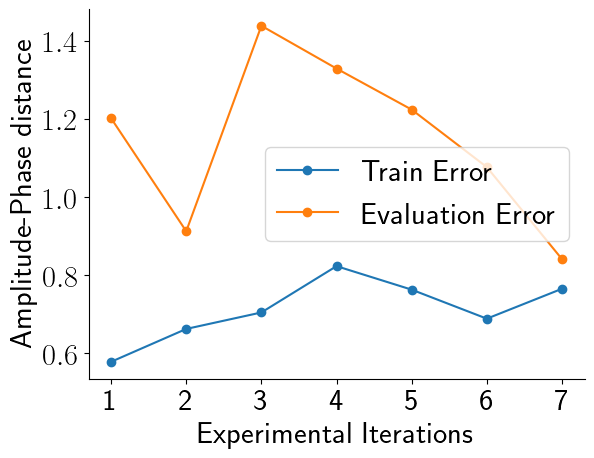

In [8]:
train = np.asarray([y[0] for _,y in accuracies.items()]).squeeze()
test = np.asarray([y[1] for _,y in accuracies.items()]).squeeze()
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    xticks = np.arange(1, TOTAL_ITERATIONS)
    ax.plot(xticks, train,  "-o", label="Train Error")
    ax.plot(xticks, test,  "-o", label="Evaluation Error")
    ax.legend()
    xlabels = ["%d"%x for x in xticks]
    ax.set_xticks(xticks, labels=xlabels)
    ax.set_xlabel("Experimental Iterations")
    ax.set_ylabel("Amplitude-Phase distance")
    plt.savefig("./figures/train_eval_apdist.png")
    plt.show()

In [9]:
np.savez("./accuracy.npz", train, test)

### Test two different approaches to computing warping functions

In [7]:
rid = np.random.randint(0, next_comps.shape[0])
comp = next_comps[rid,:].reshape(-1,1)
c = torch.from_numpy(comp).to(device)

tt = torch.from_numpy(next_time).to(device)
x_target = tt.repeat(comp.shape[0]).view(comp.shape[0], len(next_time), 1)
y_true = torch.from_numpy(next_spectra[rid,:]).to(device)

with torch.no_grad():
    gp_model.eval()
    normalized_x = normalize(c, expt.bounds.to(c))
    posterior = gp_model.posterior(normalized_x)

    mu = []
    for _ in range(250):
        mu_i, _ = np_model.xz_to_y(x_target, posterior.rsample().squeeze(0))
        mu.append(mu_i)

    y_pred = torch.cat(mu).mean(dim=0, keepdim=True).squeeze()
optim_kwargs = {"n_iters":50, 
                "n_basis":10, 
                "n_layers":10,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":len(next_time),
                "eps":0.1,
                "verbose":0,
                }
amplitude, phase, output = amplitude_phase_distance(tt, y_true, y_pred, **optim_kwargs)

Distances from Deep learning :  tensor(0.4905) tensor(0.6103)


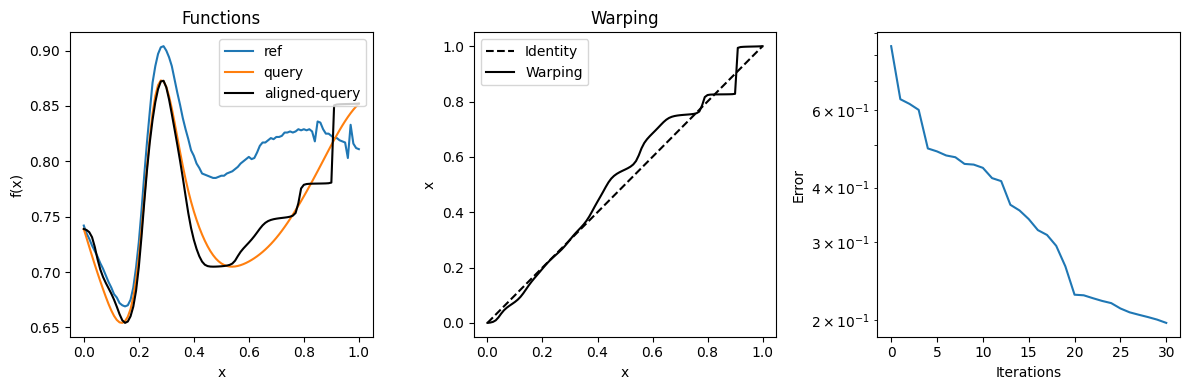

In [8]:
print("Distances from Deep learning : ", amplitude, phase)
warping = output[0]
fig, axs =plt.subplots(1,3, figsize=(4*3, 4))

axs[0].plot(tt, y_true, label="ref")
axs[0].plot(tt, y_pred, label="query")
f2_ = Function(tt, y_pred.reshape(-1,1))
axs[0].plot(tt, f2_(warping.fx).squeeze(), color="k", label="aligned-query")
axs[0].legend()
axs[0].set(xlabel="x", ylabel="f(x)", title="Functions")

axs[1].plot(tt, tt, label="Identity", color="k", ls='--')
axs[1].plot(tt, warping.fx, color="k", label="Warping")
axs[1].set(xlabel="x", ylabel="x", title="Warping")
axs[1].legend()

axs[2].semilogy(output[-1])
axs[2].set(xlabel="Iterations", ylabel="Error")

plt.tight_layout()
plt.show() 

Distances from Dynamic Programming :  0.4485775365463359 0.39911445265392015


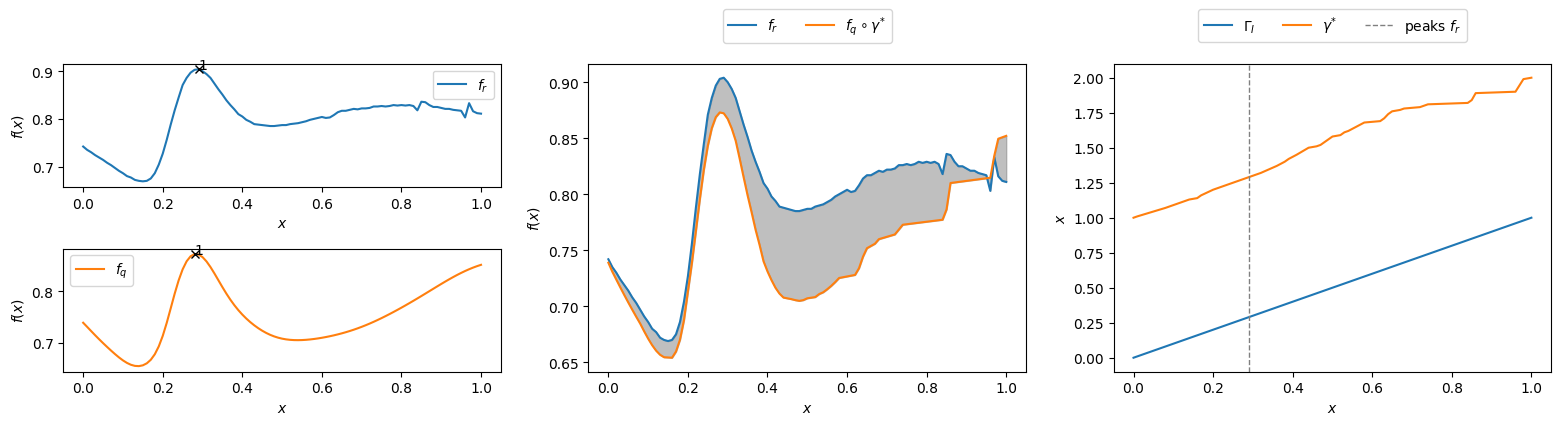

In [9]:
optim_kwargs = {"optim":"DP", "grid_dim":10}
amplitude, phase = dist(next_time, y_true.numpy(), y_pred.numpy(), **optim_kwargs)
print("Distances from Dynamic Programming : ", amplitude, phase)

# for SRSF representation, we map the domain into [0,1]
srsf = SRSF_(next_time)
q_ref = srsf.to_srsf(y_true.numpy())
q_query = srsf.to_srsf(y_pred.numpy())
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(y_pred.numpy(), gamma)
plot_warping(next_time, y_true.numpy(), y_pred.numpy(),f_query_gamma, gamma)
plt.show()